Gap Type Probabilities:
gap_type
0    0.528543
1    0.120215
2    0.292142
3    0.059100
Name: proportion, dtype: float64

Session Classification Probabilities:
session_classification
0    0.886501
1    0.113499
Name: proportion, dtype: float64

Close vs Prev Range Probabilities:
close_vs_prev_range
0    0.417058
1    0.582942
Name: proportion, dtype: float64


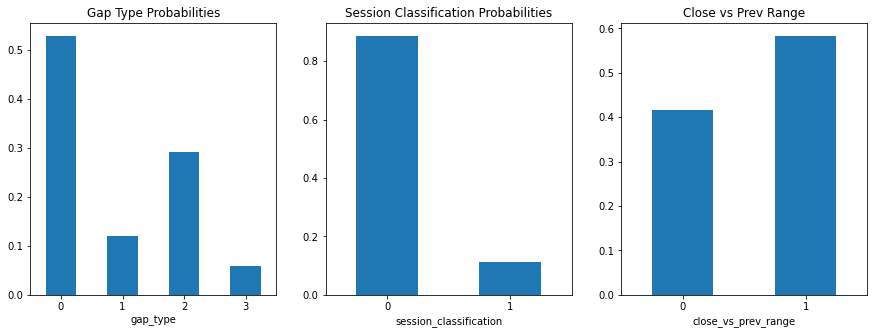

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# ─── Load and Prepare Raw Data ────────────────────────────────────────────────
df = pd.read_csv('1_es.txt')
df.columns = df.columns.str.strip().str.lower()

df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df.set_index('datetime', inplace=True)
df.drop(columns=['date', 'time'], inplace=True)
df.sort_index(inplace=True)

# ─── Filter for Valid Trading Sessions ────────────────────────────────────────
df = df.between_time('07:00', '15:59')
session_counts = df.groupby(df.index.normalize()).size()
valid_dates = session_counts[session_counts == 540].index
df = df[df.index.normalize().isin(valid_dates)].copy()

# ─── Preserve Raw Gap Data ────────────────────────────────────────────────────
df_gap = df.copy()

# ─── Aggregate into 2-Minute Buckets ──────────────────────────────────────────
df['bucket'] = df.index.floor('2min')
df = df.groupby('bucket').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'last': 'last',
    'volume': 'sum',
    'numberoftrades': 'sum',
    'bidvolume': 'sum',
    'askvolume': 'sum'
}).sort_index().copy()

# ─── Build Session-Level Summary ──────────────────────────────────────────────
session_summary = df.groupby(df.index.date).agg({
    'high': 'max',
    'low': 'min'
}).rename(columns={'high': 'session_high', 'low': 'session_low'})

session_summary['prev_high'] = session_summary['session_high'].shift(1)
session_summary['prev_low'] = session_summary['session_low'].shift(1)

# Add last close of the day
session_summary['session_close'] = df.groupby(df.index.date)['last'].last().values

# Inside (0) / Outside (1) previous day's range
def close_vs_prev(row):
    if pd.isna(row['prev_high']) or pd.isna(row['prev_low']):
        return None
    return 0 if row['prev_low'] <= row['session_close'] <= row['prev_high'] else 1

session_summary['close_vs_prev_range'] = session_summary.apply(close_vs_prev, axis=1)

# ─── Range Overlap Classification ────────────────────────────────────────────
def overlaps(row):
    return row['session_low'] <= row['prev_high'] and row['session_high'] >= row['prev_low']

session_summary['range_overlap'] = session_summary.apply(overlaps, axis=1)
session_summary['session_classification'] = session_summary['range_overlap'].apply(lambda x: 0 if x else 1)

# ─── Extract 07:00 and 09:30 Opens ────────────────────────────────────────────
target_times = [pd.to_datetime('07:00').time(), pd.to_datetime('09:30').time()]
open_times = df[df.index.map(lambda x: x.time() in target_times)]
open_prices = open_times.groupby(open_times.index.date)['open'].agg(list)

gap_df = pd.DataFrame(open_prices.tolist(), index=open_prices.index, columns=['open_0700', 'open_0930'])
gap_df['prev_high'] = session_summary['session_high'].shift(1)
gap_df['prev_low'] = session_summary['session_low'].shift(1)

# ─── Gap Classification ──────────────────────────────────────────────────────
def classify_gap(row):
    o7, o9, ph, pl = row['open_0700'], row['open_0930'], row['prev_high'], row['prev_low']
    if pd.isna(ph) or pd.isna(pl):
        return 4  # Catch-All
    in_range_07 = pl <= o7 <= ph
    in_range_09 = pl <= o9 <= ph

    if in_range_07 and in_range_09:
        return 0  # No Gap
    elif in_range_07 and not in_range_09:
        return 1  # Morning Gap
    elif not in_range_07 and not in_range_09:
        return 2  # Overnight & Morning Gap
    elif not in_range_07 and in_range_09:
        return 3  # Fake Gap
    return 4  # Catch-All

gap_df['gap_type'] = gap_df.apply(classify_gap, axis=1)

# ─── Combine Gap and Session Classification ───────────────────────────────────
combined_df = pd.DataFrame({
    'gap_type': gap_df['gap_type'],
    'session_classification': session_summary['session_classification'],
    'close_vs_prev_range': session_summary['close_vs_prev_range']
}).dropna().reset_index().rename(columns={'index': 'session_date'})

# ─── Clean and Prepare combined_df ────────────────────────────────────────────
combined_df['session_date'] = pd.to_datetime(combined_df['session_date'])
combined_df.set_index('session_date', inplace=True)
combined_df.sort_index(inplace=True)
combined_df[['session_classification','close_vs_prev_range']] = combined_df[['session_classification','close_vs_prev_range']].astype(int)
combined_df = combined_df.iloc[1:]  # drop first row (needs previous day)

# ─── Probabilities ────────────────────────────────────────────────────────────
gap_counts = combined_df['gap_type'].value_counts(normalize=True).sort_index()
print("Gap Type Probabilities:")
print(gap_counts)

session_counts = combined_df['session_classification'].value_counts(normalize=True).sort_index()
print("\nSession Classification Probabilities:")
print(session_counts)

close_counts = combined_df['close_vs_prev_range'].value_counts(normalize=True).sort_index()
print("\nClose vs Prev Range Probabilities:")
print(close_counts)

# ─── Plot ────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

gap_counts.plot(kind='bar', ax=axes[0], title="Gap Type Probabilities", rot=0)
session_counts.plot(kind='bar', ax=axes[1], title="Session Classification Probabilities", rot=0)
close_counts.plot(kind='bar', ax=axes[2], title="Close vs Prev Range", rot=0)

plt.show()

# # No Gap = 0 --- in_range_07 and in_range_0930
# # Morning Gap = 1 --- in_range_07 and not in_range_0930
# # Overnight and Morning Gap = 2 --- not in_range_07 and not in_range_0930
# # Fake Gap = 3 --- not in_range_07 and in_range_0930

In [9]:
df

,open,high,low,last,volume,numberoftrades,bidvolume,askvolume
bucket,,,,,,,,
2018-08-06 07:00:00,2842.50,2843.00,2842.25,2842.25,454,227,232,222
2018-08-06 07:02:00,2842.25,2843.00,2842.25,2843.00,1309,327,570,739
2018-08-06 07:04:00,2843.00,2843.00,2842.00,2842.00,424,167,298,126
2018-08-06 07:06:00,2842.25,2842.75,2842.25,2842.75,294,166,138,156
2018-08-06 07:08:00,2842.75,2842.75,2842.25,2842.75,312,131,168,144
...,...,...,...,...,...,...,...,...
2024-08-09 15:50:00,5369.75,5372.25,5364.50,5367.75,9691,7442,5145,4546
2024-08-09 15:52:00,5368.00,5369.25,5363.75,5364.75,7240,5331,3892,3348
2024-08-09 15:54:00,5364.50,5365.50,5360.25,5364.00,13131,9636,7497,5634



Conditional Probabilities (Close vs Prev Range | Gap Type):
close_vs_prev_range         0         1
gap_type                               
0                    0.536213  0.463787
1                    0.385475  0.614525
2                    0.218391  0.781609
3                    0.397727  0.602273


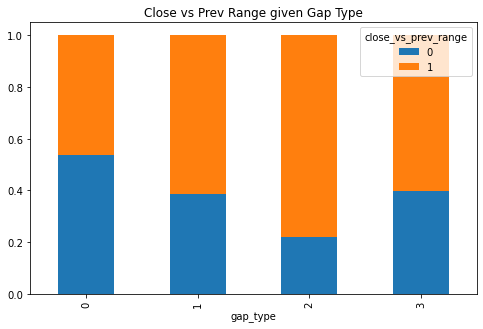

In [10]:
# ─── Joint Probabilities: Close vs Prev Range | Gap Type ──────────────────────
joint_close = pd.crosstab(
    combined_df['gap_type'],
    combined_df['close_vs_prev_range'],
    normalize='index'
)

print("\nConditional Probabilities (Close vs Prev Range | Gap Type):")
print(joint_close)

# Plot
joint_close.plot(
    kind="bar", stacked=True, figsize=(8,5),
    title="Close vs Prev Range given Gap Type"
)
plt.show()


Conditional Probabilities (Close vs Prev Range | Gap Type):
close_vs_prev_range         0         1
gap_type                               
0                    0.536213  0.463787
1                    0.385475  0.614525
2                    0.218391  0.781609
3                    0.397727  0.602273


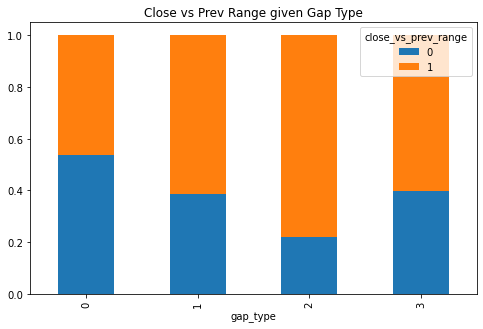


Conditional Probabilities (Close vs Prev Range | Session Classification):
close_vs_prev_range            0         1
session_classification                    
0                       0.470455  0.529545
1                       0.000000  1.000000


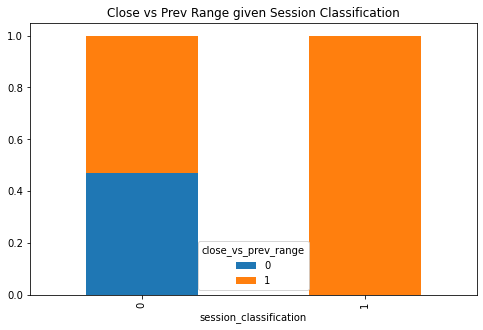

In [11]:
# ─── Joint Probabilities: Close vs Prev Range | Gap Type ──────────────────────
joint_close_gap = pd.crosstab(
    combined_df['gap_type'],
    combined_df['close_vs_prev_range'],
    normalize='index'
)

print("\nConditional Probabilities (Close vs Prev Range | Gap Type):")
print(joint_close_gap)

joint_close_gap.plot(
    kind="bar", stacked=True, figsize=(8,5),
    title="Close vs Prev Range given Gap Type"
)
plt.show()

# ─── Joint Probabilities: Close vs Prev Range | Session Classification ────────
joint_close_session = pd.crosstab(
    combined_df['session_classification'],
    combined_df['close_vs_prev_range'],
    normalize='index'
)

print("\nConditional Probabilities (Close vs Prev Range | Session Classification):")
print(joint_close_session)

joint_close_session.plot(
    kind="bar", stacked=True, figsize=(8,5),
    title="Close vs Prev Range given Session Classification"
)
plt.show()

In [12]:
def flow_counts(df, gap_type, session_classification, close_vs_prev_range):
    """
    Calculate counts of a specific path:
    Gap Type -> Session Classification -> Close vs Prev Range
    
    Parameters:
        df : DataFrame
            Must contain 'gap_type', 'session_classification', 'close_vs_prev_range'
        gap_type, session_classification, close_vs_prev_range : int
            Path to filter (0 or 1 values)
    
    Returns:
        dict with intermediate and final counts
    """
    total_days = len(df)

    # Step 1: Filter gap type
    gap_df = df[df['gap_type'] == gap_type]
    gap_count = len(gap_df)

    # Step 2: Filter session classification
    session_df = gap_df[gap_df['session_classification'] == session_classification]
    session_count = len(session_df)

    # Step 3: Filter close vs prev range
    close_df = session_df[session_df['close_vs_prev_range'] == close_vs_prev_range]
    close_count = len(close_df)

    return {
        "total_days": total_days,
        "gap_count": gap_count,
        "session_count": session_count,
        "close_count": close_count
    }

# Example usage:
result = flow_counts(combined_df, gap_type=0, session_classification=0, close_vs_prev_range=0)

gap, session, close = 0, 0, 0
result = flow_counts(combined_df, gap_type=gap, session_classification=session, close_vs_prev_range=close)
# Compute the final ratio
joint_ratio = result['close_count'] / result['total_days'] if result['total_days'] > 0 else 0

print("Joint ratio (close_count / total_days):", joint_ratio)

print(f"Flow {gap},{session},{close} → Joint ratio: {joint_ratio:.4f} "
      f"(Close count: {result['close_count']}, Total days: {result['total_days']})")

Joint ratio (close_count / total_days): 0.2834116856950974
Flow 0,0,0 → Joint ratio: 0.2834 (Close count: 422, Total days: 1489)


Flow 0,0,0 → Joint ratio: 0.2834 (Close count: 422, Total days: 1489)
Flow 0,0,1 → Joint ratio: 0.2451 (Close count: 365, Total days: 1489)
Flow 0,1,0 → Joint ratio: 0.0000 (Close count: 0, Total days: 1489)
Flow 0,1,1 → Joint ratio: 0.0000 (Close count: 0, Total days: 1489)
Flow 1,0,0 → Joint ratio: 0.0463 (Close count: 69, Total days: 1489)
Flow 1,0,1 → Joint ratio: 0.0739 (Close count: 110, Total days: 1489)
Flow 1,1,0 → Joint ratio: 0.0000 (Close count: 0, Total days: 1489)
Flow 1,1,1 → Joint ratio: 0.0000 (Close count: 0, Total days: 1489)
Flow 2,0,0 → Joint ratio: 0.0638 (Close count: 95, Total days: 1489)
Flow 2,0,1 → Joint ratio: 0.1148 (Close count: 171, Total days: 1489)
Flow 2,1,0 → Joint ratio: 0.0000 (Close count: 0, Total days: 1489)
Flow 2,1,1 → Joint ratio: 0.1135 (Close count: 169, Total days: 1489)
Flow 3,0,0 → Joint ratio: 0.0235 (Close count: 35, Total days: 1489)
Flow 3,0,1 → Joint ratio: 0.0356 (Close count: 53, Total days: 1489)
Flow 3,1,0 → Joint ratio: 0.0000 (

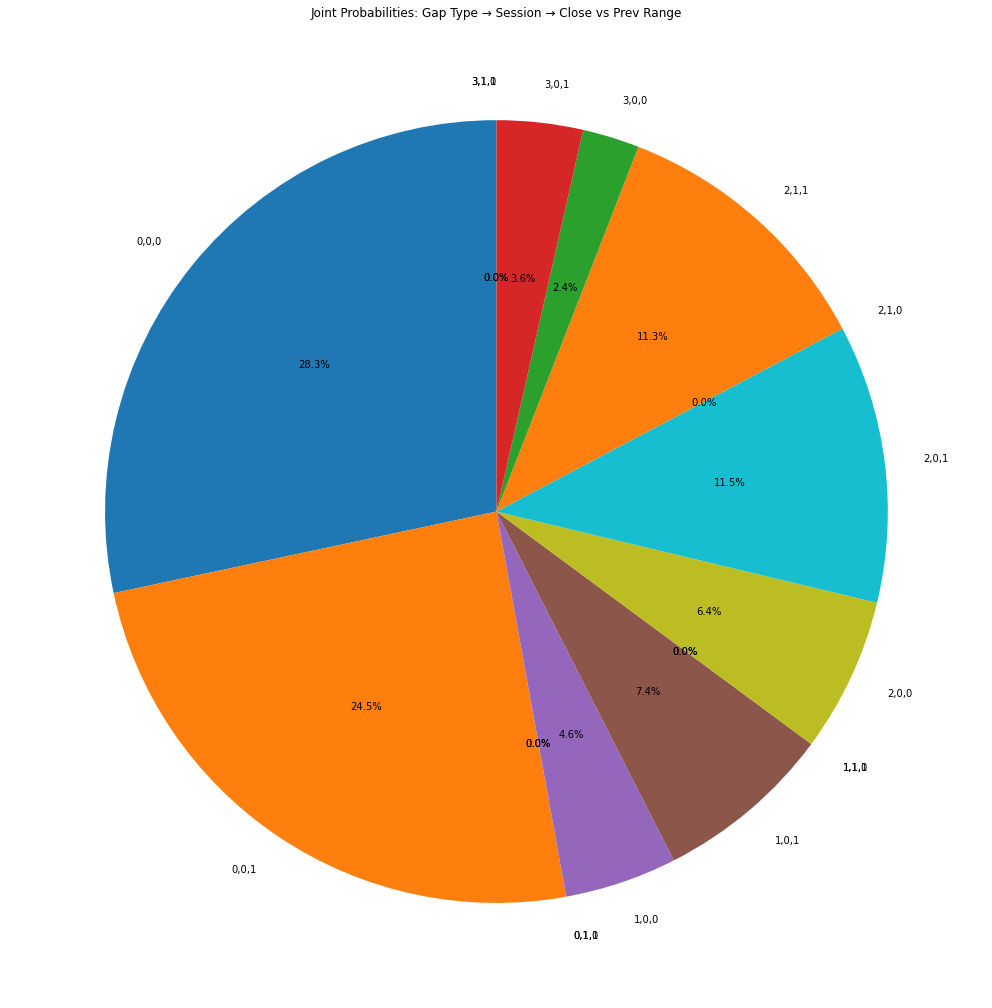

In [13]:
# Function already defined: flow_counts(df, gap_type, session_classification, close_vs_prev_range)

# ─── Compute all possible flows ──────────────────────────────────────────────
flows = []
total_days = len(combined_df)

for gap in [0,1,2,3]:
    for session in [0,1]:
        for close in [0,1]:
            result = flow_counts(combined_df, gap_type=gap, session_classification=session, close_vs_prev_range=close)
            joint_ratio = result['close_count'] / total_days if total_days > 0 else 0
            flows.append({
                'flow': f"{gap},{session},{close}",
                'close_count': result['close_count'],
                'joint_ratio': joint_ratio
            })

flow_df = pd.DataFrame(flows)

# ─── Print nicely ──────────────────────────────────────────────────────────
for idx, row in flow_df.iterrows():
    print(f"Flow {row['flow']} → Joint ratio: {row['joint_ratio']:.4f} "
          f"(Close count: {row['close_count']}, Total days: {total_days})")

# ─── Pie chart of all joint probabilities ───────────────────────────────────
plt.figure(figsize=(18,18))
plt.pie(flow_df['joint_ratio'], labels=flow_df['flow'], autopct='%1.1f%%', startangle=90)
plt.title("Joint Probabilities: Gap Type → Session → Close vs Prev Range")
plt.show()

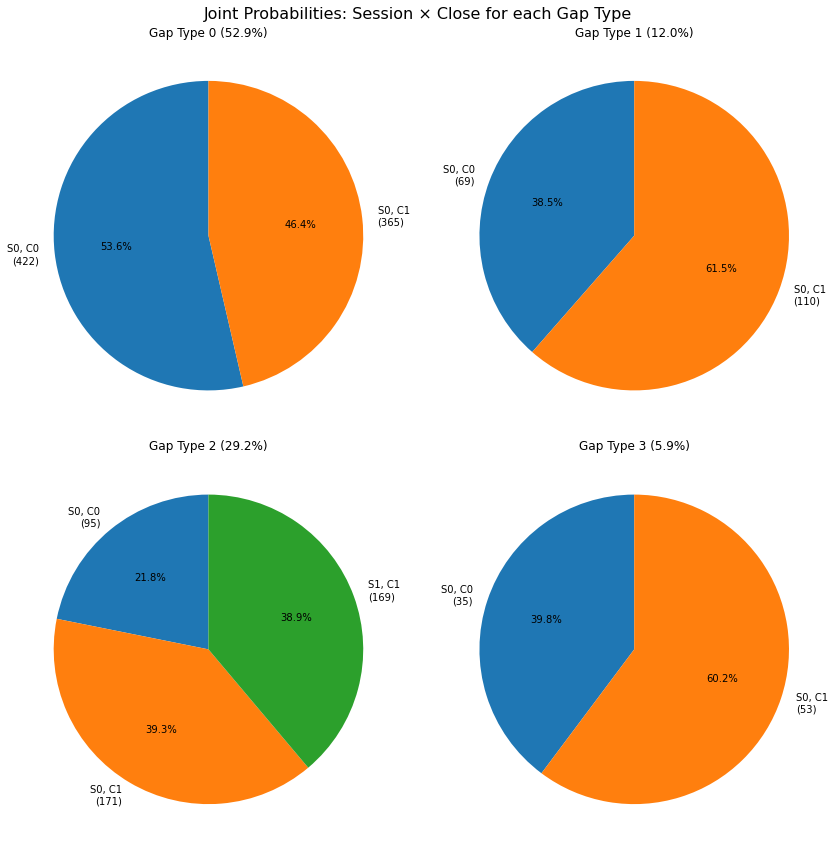

In [14]:
# Prepare flows
flows = []
total_days = len(combined_df)

for gap in [0,1,2,3]:
    for session in [0,1]:
        for close in [0,1]:
            result = flow_counts(combined_df, gap_type=gap, session_classification=session, close_vs_prev_range=close)
            joint_ratio = result['close_count'] / total_days if total_days > 0 else 0
            flows.append({
                'gap': gap,
                'session': session,
                'close': close,
                'close_count': result['close_count'],
                'joint_ratio': joint_ratio
            })

flow_df = pd.DataFrame(flows)

# 2x2 grid of pies
fig, axes = plt.subplots(2, 2, figsize=(12,12), facecolor='white')
axes = axes.flatten()

for i, gap in enumerate([0,1,2,3]):
    subset = flow_df[(flow_df['gap'] == gap) & (flow_df['joint_ratio'] > 0)]  # remove 0%
    labels = [f"S{s}, C{c}\n({cnt})" for s, c, cnt in zip(subset['session'], subset['close'], subset['close_count'])]
    sizes = subset['joint_ratio']
    
    # Compute total probability for this gap type
    gap_total_pct = subset['joint_ratio'].sum() * 100

    axes[i].pie(
        sizes, labels=labels, autopct='%1.1f%%', startangle=90,
        textprops={'color':'black'}
    )
    axes[i].set_title(f"Gap Type {gap} ({gap_total_pct:.1f}%)", color='black')

plt.suptitle("Joint Probabilities: Session × Close for each Gap Type", fontsize=16, color='black')
plt.tight_layout()
plt.show()